<a href="https://colab.research.google.com/github/davidelgas/DataSciencePortfolio/blob/main/NLP_with_RAG/notebooks/NLP_with_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project Scope and Limitations


Use Case Detailing: Elaborate on how the virtual mechanic will interact with users. Describe example queries and responses to illustrate practical usage.
Impact on Stakeholders: Discuss the expected impact this project could have on various stakeholders, including car owners and BMW clubs.


## 1.1 Project Overview
This project aims to build a generative language model capable of processing written, unstructured questions in English from users and providing targeted written answers. The  use case for this project is a virtual mechanic to help owners maintain a specific make and model of classic car: the BMW 3.0 CS. The results of this effort will be provided to several international BMW clubs to solicity feedback on usability and potential extension to other makes and models.



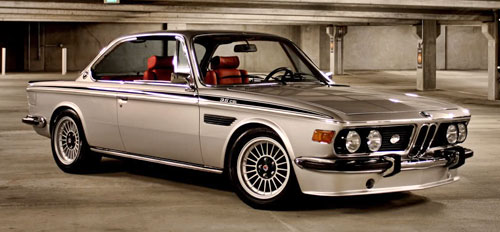

In [1]:

Image('/content/drive/MyDrive/Colab Notebooks/NLP/BMW_E9.jpg')

1972 - 1974 BMW 3.0 CS

## 1.2 Objectives
The primary objective of this project is the development of a Natural Language Processing (NLP) model as part of a portfolio of AI projects that can be showcased to potential employers. This will include an outline of the necessary workflow with a comparision and selection of architectures, libraries and methods. This is a complement to my pursuit of a Masters Degree in Data Science.

Measurable Outcomes: Define specific, measurable outcomes to gauge success, such as accuracy metrics or user satisfaction rates.
Workflow Diagram: Include a flowchart or diagram that outlines the entire project workflow for visual representation.

## 1.3 Limitations and Challenges
Python will be the primary programming language. Google Colab will be used for the notebook with compute resources limited to CPUs. Data storage will be done in a Snowflake database. Where possible, a combination of open source and free resource will be used.

Resource Constraints: Discuss the impact of CPU-only resources on model training and inference times.
Data Privacy: Address how data privacy will be ensured when handling user-generated data, particularly concerning personally identifiable information (PII).

In [2]:
# Access to Google Drive
# This seems to propagate credentials better from its own cell

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Install libraries

from IPython.display import Image

# Data Collection
import os

!pip3 install pandas
import pandas as pd

!pip3 install requests
import requests

!pip3 install beautifulsoup4
from bs4 import BeautifulSoup

!pip install snowflake-connector-python
import snowflake.connector

# Data Preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from gensim.parsing.preprocessing import STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer as lemmatizer


import re

!pip install langdetect
from langdetect import detect

from transformers import BertTokenizer, BertModel, pipeline

import torch

!pip3 install numpy
import numpy as np

!pip install faiss-cpu
import faiss

!pip install langdetect
from langdetect import detect


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Data Collection and Preprocessing





## 2.1 Data Ethics


"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

## 2.2 Data Collection




The project leverages user-generated content from a domain-specific online forum as the training corpus. This data is largely unstructured, with minimal metadata available. The following tools were considered to gather the source text for the corpus:


### Web Scraping
- **Tools:** Beautiful Soup, online SaaS products
    - **Pros:**
        - **Direct Access to Targeted Data:** Enables precise extraction of user-generated content from specific sections or threads within the forum.
        - **Efficiency in Data Collection:** Automated scripts can gather large volumes of data in a short amount of time, making it suitable for assembling significant datasets for NLP.
    - **Cons:**
        - **Potential for Incomplete Data:** May miss embedded content or dynamically loaded data, depending on the website’s structure.
        - **Ethical and Legal Considerations:** Scraping data from forums may raise concerns about user privacy and must adhere to the terms of service of the website.
        - **Very Platform Dependent:** Forum specific solutions result in forum specific data schemas that must be reverse engineered to for successful text extraction.

### Forum-specific APIs
- **Tools:** Python (`requests` library for API calls and `json` library for handling responses)
    - **Pros:**
        - **Structured and Reliable Data Retrieval:** APIs provide structured data, making it easier to process and integrate into your project.
        - **Efficient and Direct Access:** Directly accessing the forum's data through its API is efficient, bypassing the need for HTML parsing.
        - **Compliance and Ethical Data Use:** Utilizing APIs respects the forum's data use policies and ensures access is in line with user agreements.
    - **Cons:**
        - **Rate Limiting:** APIs often have limitations on the number of requests that can be made in a certain timeframe, which could slow down data collection.
        - **API Changes:** Dependence on the forum's API structure means that changes or deprecation could disrupt your data collection pipeline.
        - **Access Restrictions:** Some data or functionalities might be restricted or require authentication, posing additional challenges for comprehensive data collection.


**Conclusion: I will be using Beautiful Soup to create my corpus.**


In [5]:
# Create Corpus

# Set the base path to save files
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/'

# Create URLs from the thread_ids and save to a CSV
def create_urls():
    # Define the file path inside the function using the correct base path
    file_path = BASE_PATH + 'e9_forum_thread_ids.csv'

    # Set the number of incremental thread_ids to process
    threads = 1

    # Check if the file exists and has content. If it does, update last_thread_id
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        e9_forum_thread_ids = pd.read_csv(file_path)
        last_thread_id = e9_forum_thread_ids['thread_id'].iloc[-1]
        last_thread_id = int(last_thread_id)  # Convert to integer
    else:
        last_thread_id = 0

    urls = []
    for thread_id in range(last_thread_id + 1, last_thread_id + threads + 1):
        urls.append({'thread_id': thread_id})

    last_thread_id_processed = urls[-1]['thread_id']

    # Convert the list of dictionaries into a DataFrame
    e9_forum_thread_ids = pd.DataFrame(urls)

    # Save DataFrame to CSV file
    e9_forum_thread_ids.to_csv(file_path, mode='a', header=not os.path.exists(file_path), index=False)

    print("Starting with thread_id " + str(last_thread_id))
    print("Processing additional " + str(threads) + " threads")
    print("Ending with thread_id " + str(last_thread_id_processed))


    return last_thread_id, last_thread_id_processed, e9_forum_thread_ids

# Ingest thread_ids and return title, id and URL
def fetch_thread_data(df):
    # Define the file path inside the function using the correct base path
    file_path = BASE_PATH + 'e9_forum_threads.csv'

    # Set the number of pages to process
    pages = 1

    for index, row in df.iterrows():
        thread_id = row['thread_id']
        thread_url = f"https://e9coupe.com/forum/threads/{thread_id}"
        for i in range(1, pages + 1):
            page_url = f"{thread_url}/?page={i}"  # Construct the page URL
            response = requests.get(page_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            title = soup.find('title').get_text()
            thread_title = title.split('|')[0].strip()
            df.at[index, 'thread_title'] = thread_title
            df.at[index, 'thread_url'] = page_url

    df.to_csv(file_path, mode='a', header=not os.path.exists(file_path), index=False)

    return df

# Find the first post in the thread creation
def fetch_first_post_content(df):
    # Define the file path inside the function using the correct base path
    file_path = BASE_PATH + 'e9_forum_threads_decorated.csv'

    data = []

    for thread_id, thread_url, thread_title in zip(df['thread_id'], df['thread_url'], df['thread_title']):
        response = requests.get(thread_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        first_post = soup.find('article', class_='message-body')
        if first_post:
            post_content = first_post.get_text(strip=True)
        else:
            post_content = "No content found"  # Handle case where no post content is found

        data.append({'thread_id': thread_id, 'thread_title': thread_title, 'thread_first_post': post_content})

    # Convert list of dictionaries to DataFrame
    e9_forum_threads_decorated = pd.DataFrame(data)

    # Export and save result
    e9_forum_threads_decorated.to_csv(file_path, mode='a', header=not os.path.exists(file_path), index=False)

    return e9_forum_threads_decorated


# Original UDF to fetch and parse thread posts
def fetch_and_parse_thread(df):
    post_data = []
    processed_posts = set()
    for index, row in df.iterrows():
        response = requests.get(row['thread_url'])
        soup = BeautifulSoup(response.text, 'html.parser')
        articles = soup.find_all('article', class_='message--post')
        for article in articles:
            post_timestamp = article.find('time')['datetime'] if article.find('time') else 'N/A'
            content = article.find('div', class_='bbWrapper').get_text(strip=True)

            post_data.append({
                'thread_id': row['thread_id'],
                'post_timestamp': post_timestamp,
                'post_raw': content
            })

    e9_forum_posts = pd.DataFrame(post_data)

    e9_forum_posts['post_raw'] = e9_forum_posts['post_raw'].astype(str)

    # Define the output path
    output_path = os.path.join(BASE_PATH, 'e9_forum_posts.csv')

    # Export and save result
    e9_forum_posts.to_csv(output_path, index=False)

    return e9_forum_posts


# Define the UDF to process the data
def create_forum_corpus(e9_forum_posts, e9_forum_threads_decorated):

    # Group by THREAD_ID and concatenate the POST_RAW values
    aggregated_data = e9_forum_posts.groupby('thread_id')['post_raw'].agg(lambda x: ' '.join(x)).reset_index()

    # Rename the column to indicate that it contains concatenated post content
    aggregated_data.rename(columns={'post_raw': 'thread_all_posts'}, inplace=True)

    # Ensure thread_id columns are of type int64
    e9_forum_threads_decorated['thread_id'] = e9_forum_threads_decorated['thread_id'].astype('int64')
    aggregated_data['thread_id'] = aggregated_data['thread_id'].astype('int64')

    # Merge the two DataFrames
    e9_forum_corpus = pd.merge(e9_forum_threads_decorated, aggregated_data, on='thread_id', how='left')

    # Define the output path
    output_path = os.path.join(BASE_PATH, 'e9_forum_corpus.csv')

    # Export and save result
    e9_forum_corpus.to_csv(output_path, index=False)

    return e9_forum_corpus

def main():
    # Execute the function and print results
    last_thread_id, last_thread_id_processed, e9_forum_thread_ids = create_urls()

    # Fetch thread URLs and title
    e9_forum_threads = fetch_thread_data(e9_forum_thread_ids)

    # Fetch first post content
    e9_forum_threads_decorated = fetch_first_post_content(e9_forum_threads)

    # Fetch all thread post content
    e9_forum_posts = fetch_and_parse_thread(e9_forum_threads)

    e9_forum_corpus = create_forum_corpus(e9_forum_posts, e9_forum_threads_decorated)


# Ensure the main function is called
if __name__ == "__main__":
    main()




Starting with thread_id 19597
Processing additional 1 threads
Ending with thread_id 19598


## 2.3 Data Storage and Database



Efficient data storage and management are pivotal for the project, focusing on accommodating extensive unstructured data from various sources. The project explores two main classes of storage solutions: Cloud Storage and Local Storage, each offering unique benefits and challenges.

### Cloud Storage
Cloud storage solutions offer scalability, reliability, and remote access, making them suitable for projects with dynamic data needs and global access requirements.

- **Tools:** Snowflake (for relational data), MongoDB Atlas (for NoSQL data)
    - **Pros:**
        - **Scalability:** Easily scales to meet growing data demands without the need for physical infrastructure management.
        - **Accessibility:** Provides global access to the data, facilitating collaboration and remote work.
        - **Maintenance and Security:** Cloud providers manage the security, backups, and maintenance, reducing the administrative burden.
    - **Cons:**
        - **Cost:** While scalable, costs can increase significantly with data volume and throughput.
        - **Internet Dependence:** Requires consistent internet access, which might be a limitation in some scenarios.
        - **Data Sovereignty:** Data stored in the cloud may be subject to the laws and regulations of the host country, raising concerns about compliance and privacy.

### Local Storage
Local storage solutions rely on on-premises or personal hardware, providing full control over the data and its management but requiring more direct oversight.

- **Tools:** MySQL (for relational data), MongoDB (Local installation for NoSQL data)
    - **Pros:**
        - **Control:** Complete control over the data storage environment and configurations.
        - **Cost:** No ongoing costs related to data storage size or access rates, aside from initial hardware and setup.
        - **Connectivity:** No reliance on internet connectivity for access, ensuring data availability even in offline scenarios.
    - **Cons:**
        - **Scalability:** Physical limits to scalability; expanding storage capacity requires additional hardware.
        - **Maintenance:** Requires dedicated resources for maintenance, backups, and security, increasing the administrative burden.
        - **Accessibility:** Data is not as easily accessible from remote locations, potentially hindering collaboration and remote access needs.


**Conclusion: I will be using Snowflake to store my corpus.**

In [6]:
# Store Corpus


BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/'
CREDENTIALS_PATH = '/content/drive/MyDrive/Colab Notebooks/credentials/snowflake_credentials'

# Load the e9_forum_corpus DataFrame from the CSV file
e9_forum_corpus = pd.read_csv(BASE_PATH + 'e9_forum_corpus.csv')

def load_credentials(credentials_path):
    """Load Snowflake credentials from a file and set them as environment variables."""
    with open(credentials_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            os.environ[key] = value

def connect_to_snowflake():
    """Establish a connection to the Snowflake database."""
    return snowflake.connector.connect(
        user=os.environ.get('USER'),
        password=os.environ.get('PASSWORD'),
        account=os.environ.get('ACCOUNT')
    )

def create_db_and_schema(cur):
    """Create the database and schema in Snowflake."""
    try:
        cur.execute("CREATE DATABASE IF NOT EXISTS e9_corpus")
        cur.execute("USE DATABASE e9_corpus")
        cur.execute("CREATE SCHEMA IF NOT EXISTS e9_corpus_schema")
        print("Database and schema created successfully.")
    except Exception as e:
        print(f"Error creating database and schema: {e}")

def create_table_if_not_exists(cur):
    """Create the e9_forum_corpus table if it does not exist."""
    try:
        cur.execute("""
        CREATE TABLE IF NOT EXISTS e9_corpus.e9_corpus_schema.e9_forum_corpus (
            thread_id NUMBER(38,0),
            thread_title VARCHAR(16777216),
            thread_first_post VARCHAR(16777216),
            thread_all_posts VARCHAR(16777216)
        )
        """)
        print("e9_forum_corpus table created successfully.")
    except Exception as e:
        print(f"Error creating table: {e}")

def insert_data_into_table(cur, df):
    """Insert data from the DataFrame into the e9_forum_corpus table."""
    for index, row in df.iterrows():
        row = row.where(pd.notnull(row), None)
        insert_command = f"""
        INSERT INTO e9_corpus.e9_corpus_schema.e9_forum_corpus
        (thread_id, thread_title, thread_first_post, thread_all_posts)
        VALUES (%s, %s, %s, %s)
        """
        try:
            cur.execute(insert_command, (
                row['thread_id'], row['thread_title'],
                row['thread_first_post'], row['thread_all_posts']
            ))
        except Exception as e:
            print(f"Error inserting data: {e}")

def fetch_data_from_table(cur):
    """Fetch all data from the e9_forum_corpus table."""
    query = "SELECT * FROM e9_corpus.e9_corpus_schema.e9_forum_corpus"
    cur.execute(query)
    return cur.fetch_pandas_all()

def main():
    # Load Snowflake credentials
    load_credentials(CREDENTIALS_PATH)

    # Connect to Snowflake
    conn = connect_to_snowflake()
    cur = conn.cursor()

    # Create the database, schema, and table if they don't exist
    create_db_and_schema(cur)
    create_table_if_not_exists(cur)

    # Insert data into the table
    insert_data_into_table(cur, e9_forum_corpus)
    conn.commit()
    print("Data inserted into e9_forum_corpus table.")

    # Fetch data from the table
    e9_forum_corpus_df = fetch_data_from_table(cur)
    e9_forum_corpus_df.info()

    # Close cursor and connection
    cur.close()
    conn.close()

if __name__ == "__main__":
    main()

Database and schema created successfully.
e9_forum_corpus table created successfully.
Data inserted into e9_forum_corpus table.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16462 entries, 0 to 16461
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   THREAD_ID          16462 non-null  int16 
 1   THREAD_TITLE       16462 non-null  object
 2   THREAD_FIRST_POST  16462 non-null  object
 3   THREAD_ALL_POSTS   16154 non-null  object
dtypes: int16(1), object(3)
memory usage: 418.1+ KB


# 3. Model Selection and Architecture


**BERT (Bidirectional Encoder Representations from Transformers)**

**Pros:**
- **Bidirectional Context:** BERT captures bidirectional context during pre-training, enabling it to understand the meaning of words in their full context.

> Add blockquote


- **Versatility:** BERT is versatile and can be fine-tuned for a wide range of NLP tasks, including classification, regression, and question answering.
- **State-of-the-Art Performance:** BERT achieved state-of-the-art results on various benchmark NLP tasks, making it a reliable choice for many applications.

**Cons:**
- **Large Model Size:** BERT's model size can be large, making it resource-intensive for fine-tuning and inference, especially on devices with limited memory.
- **Computationally Expensive:** Training and fine-tuning BERT models require significant computational resources, including powerful GPUs or TPUs, which may not be accessible for all users.
- **Fixed Architecture:** BERT's architecture is fixed, limiting flexibility for customizing model structure or adding domain-specific features.

**GPT (Generative Pre-trained Transformer)**

**Pros:**
- **Generative Capability:** GPT models are capable of generating coherent and contextually relevant text, making them suitable for tasks like text completion, summarization, and dialogue generation.
- **Large Context Window:** GPT models have a large context window, allowing them to capture long-range dependencies in text and generate more contextually relevant responses.
- **Fine-tuning Flexibility:** GPT models can be fine-tuned for various downstream tasks, offering flexibility for adapting to specific applications and domains.

**Cons:**
- **Unidirectional Context:** GPT models rely on unidirectional context during pre-training, which may limit their understanding of context compared to bidirectional models like BERT.
- **Lack of Discriminative Ability:** GPT models prioritize generative capabilities over discriminative tasks like classification, which may result in suboptimal performance for tasks requiring precise classification or labeling.
- **Limited Control:** GPT models generate text based on learned patterns in the data, which may lead to generation of biased or inappropriate content without proper control mechanisms.

**T5 (Text-to-Text Transfer Transformer)**

**Pros:**
- **Text-to-Text Format:** T5 frames all NLP tasks as text-to-text problems, providing a unified framework for various tasks like translation, summarization, and question answering.
- **Multi-task Learning:** T5 is trained on a diverse set of NLP tasks simultaneously, enabling it to generalize well across different tasks and domains.
- **Fine-tuning Efficiency:** T5 fine-tuning is efficient due to its text-to-text format, allowing for easy adaptation to specific tasks with minimal additional training data.

**Cons:**
- **Complexity:** T5's architecture is complex, which may require more computational resources and expertise to train and fine-tune compared to simpler models like BERT.
- **Large Model Size:** Like other transformer-based models, T5 can have a large model size, which may pose challenges for deployment and inference on resource-constrained devices.
- **Task-specific Fine-tuning:** While T5 is capable of handling multiple tasks, fine-tuning for specific tasks may still be necessary to achieve optimal performance, requiring additional effort and resources.


## 3.1 Architectural Approaches

3.1 Architectural Approaches
Rationale for Selection: Justify why GPT2-Small is chosen over other models considering the project’s specific needs and constraints.


### 3.1.1 Pre-trained Models





- **Tools:**
  - **Libraries/Frameworks:** GPT, PyTorch, Hugging Face Transformers. These tools offer extensive collections of pre-trained models for various NLP tasks.
- **Pros:**
  - **Time and Resource Efficiency:** Saves significant time and computational resources.
  - **Immediate Advanced Capabilities:** Suitable for a wide range of applications with out-of-the-box capabilities.
  - **Accessibility:** Easily accessible through libraries and frameworks.
- **Cons:**
  - **Generic Features:** May not excel without fine-tuning on niche or domain-specific tasks.
  - **Black Box Nature:** Complex and less interpretable.
  - **Size and Complexity:** Often large and resource-intensive, posing challenges for limited-resource deployment.


**Conclusion: I will be using GPT2-Small for my pre-trained model.**
  

### 3.1.2 Scratch Models
- **Tools:**
  - **Development Environments:** Custom development often utilizes lower-level APIs or libraries for greater control over the model architecture. Examples include TensorFlow’s and PyTorch’s core libraries, along with specialized libraries for specific model components or functions.
- **Pros:**
  - **Customization:** Tailored specifically to project needs, potentially leading to better task-specific performance.
  - **Interpretability:** Easier to interpret and diagnose.
  - **Flexibility in Architecture:** Allows for experimentation with innovative architectures.
- **Cons:**
  - **Time and Resource Intensive:** Requires significant training time and resources.
  - **Data Requirements:** Needs large, often domain-specific datasets.
  - **Risk of Overfitting:** Increased risk without the vast, diverse datasets of pre-trained models.


## 3.2 Specific Model Architectures
Pros and Cons in Context: Relate each pro and con to how it specifically impacts the goals of your project. For example, discuss how the scalability of Transformer models benefits the ability to handle an increasing amount of user queries.


### 3.2.1 Retriever-Generator Models
Retriever-Generator Models combine the capabilities of a document retriever and a text generator to enhance natural language understanding and generation. By retrieving relevant documents or passages to a query and then generating responses based on this retrieved information, RAG models can provide more accurate and contextually rich outputs for tasks like question answering and information retrieval.

- **Pros:**
  - **Enhanced Contextual Understanding:** Leverages external knowledge sources for better context understanding.
  - **Improved Accuracy:** Can generate more accurate and informative responses by using retrieved documents.
  - **Flexibility:** Suitable for a wide range of applications beyond simple text generation, including complex question answering and chatbots.

- **Cons:**
  - **Increased Complexity:** Integrating retrieval and generation components adds to the model complexity.
  - **Resource Intensive:** Requires significant computational resources for both retrieving documents and generating responses.
  - **Dependency on External Sources:** The performance heavily relies on the quality and relevance of the retrieved documents.




### 3.2.2 Sequence-to-Sequence Models
Sequence-to-Sequence (Seq2Seq) models are designed for tasks where both the input and output are sequences, such as translation, text summarization, and chatbot development. They typically employ an encoder-decoder architecture where the encoder processes the input sequence, and the decoder generates the output sequence.

- **Pros:**
  - **Versatility:** Effective for a wide range of NLP tasks involving sequence generation.
  - **Contextual Understanding:** Can capture long-range dependencies and contextual information within sequences.
  - **End-to-End Learning:** Directly maps input sequences to output sequences, simplifying the training process.

- **Cons:**
  - **Complexity:** Can be computationally intensive and require significant training data.
  - **Fixed-length Bottleneck:** The fixed-length internal representation can limit the model's ability to handle very long sequences.
  - **Difficulty in Parallelization:** The sequential nature of the decoder can make it challenging to parallelize, affecting training and inference speed.


### 3.2.3 Transformer Models
Transformer Models revolutionized NLP by introducing an architecture based entirely on attention mechanisms, eliminating the need for recurrent layers. This design allows for significantly improved parallelization during training and has led to state-of-the-art performances in various NLP tasks, including language understanding, translation, and text generation.

- **Pros:**
  - **High Efficiency and Scalability:** Enables faster training and better handling of long sequences compared to RNNs and CNNs.
  - **State-of-the-Art Performance:** Achieves superior results on a broad spectrum of NLP tasks.
  - **Versatile:** Foundation models like BERT and GPT are adaptable to numerous tasks with minimal adjustments.

- **Cons:**
  - **Resource Intensive:** Requires substantial computational resources for training and fine-tuning large models.
  - **Complexity:** The architecture and the mechanisms involved are complex, which can make customization and understanding challenging.
  - **Overfitting Risk:** There's a tendency for smaller datasets to lead to overfitting, necessitating careful regularization and training strategies.

### 3.2.4 Convolutional Neural Networks (CNNs)
Convolutional Neural Networks (CNNs), primarily known for their application in image processing, are also utilized in NLP for tasks like text classification and sentiment analysis. They work by applying convolutional layers to extract and learn features from sequences of text data, making them efficient for identifying local and position-invariant patterns in text.

- **Pros:**
  - **Efficient Pattern Recognition:** Excellently identifies local and position-invariant features in text data.
  - **Highly Efficient:** CNNs are computationally efficient, making them faster to train compared to models like RNNs.
  - **Versatile Applications:** Effective for a range of NLP tasks, including classification, topic categorization, and sentiment analysis.

- **Cons:**
  - **Limited Contextual Understanding:** Struggles with capturing long-range dependencies in text due to the fixed size of convolutional filters.
  - **Overemphasis on Local Features:** May overlook the global context or the overall structure of the text, affecting tasks requiring a deeper understanding.
  - **Less Effective for Sequential Data:** Not as naturally suited for sequence-to-sequence tasks compared to RNNs or Transformer models.

### 3.2.5 Recurrent Neural Networks (RNNs)
Recurrent Neural Networks (RNNs) are a class of neural networks designed for processing sequential data, making them ideal for NLP tasks such as language modeling, text generation, and machine translation. RNNs process sequences by maintaining a hidden state that captures information about previous elements, allowing them to exhibit temporal dynamic behavior.

- **Pros:**
  - **Temporal Sequence Modeling:** Naturally suited for tasks involving sequential data, capturing temporal dependencies effectively.
  - **Flexible Input/Output Length:** Can handle variable-length input and output sequences, which is beneficial for many NLP tasks.
  - **Foundation for Advanced Models:** Serve as the basis for more complex architectures like LSTM and GRU, which address some of the RNN's limitations.

- **Cons:**
  - **Vanishing Gradient Problem:** Struggles with long-range dependencies due to gradients diminishing over long sequences, making training difficult.
  - **Computational Intensity:** Sequential nature of processing makes it less efficient in terms of parallelization and speed compared to models like Transformers.
  - **Risk of Overfitting:** Particularly for smaller datasets, RNNs can easily overfit, necessitating careful regularization.

#### 3.2.5.1 RNN Language Model Architectures

**Gated Recurrent Unit (GRU):**

**Pros:**
- **Efficient Training:** GRUs simplify the RNN architecture by merging the forget and input gates into a single update gate, reducing the model complexity and making it faster to train compared to LSTMs.
- **Flexibility in Capturing Dependencies:** GRUs provide a mechanism to adaptively capture dependencies of different time scales, making them versatile for a range of sequence modeling tasks.
- **Lesser Parameters:** With a simpler gating mechanism than LSTM, GRUs have fewer parameters, making them more efficient in terms of memory and computationally less demanding.
- **Good Performance on Smaller Datasets:** GRUs can achieve competitive performance with LSTMs on many tasks, often excelling when the dataset is relatively small.

**Cons:**
- **Limited Memory Control:** The simplified gating mechanism in GRUs might limit their ability to precisely control the flow of information across time steps compared to LSTMs.
- **Potential for Overfitting:** Due to their efficiency and capacity to model complex patterns, GRUs can be prone to overfitting, especially on smaller datasets without proper regularization.
- **Challenges with Extremely Long Sequences:** While GRUs handle long sequences better than vanilla RNNs, they can still struggle with very long dependencies, a domain where LSTMs might perform slightly better.

**Long Short-Term Memory (LSTM):**

**Pros:**
- **Advanced Memory Management:** LSTMs include three gates (input, output, and forget gates), allowing for more nuanced control over the memory cell, which helps in learning long-term dependencies more effectively.
- **Robustness to Vanishing Gradient Problem:** The architecture of LSTMs specifically addresses the vanishing gradient problem, making them capable of learning from data with long-range temporal dependencies.
- **Widespread Adoption and Support:** LSTMs have been extensively studied and applied across various domains, benefiting from a wealth of research, optimizations, and implementations.

**Cons:**
- **Computational Complexity:** The more complex architecture of LSTMs, with multiple gates and a memory cell, makes them computationally more expensive to train and infer compared to GRUs.
- **Parameter Heavy:** LSTMs have a larger number of parameters due to their intricate gating mechanism, leading to increased memory requirements and potentially longer training times.
- **Efficiency Trade-offs:** While LSTMs can capture longer dependencies better than GRUs in some cases, this advantage comes at the cost of increased computational resources and training time.


### 3.2.6 BERT (Bidirectional Encoder Representations from Transformers)
BERT revolutionized NLP by introducing a method for pre-training language representations on a large corpus and then fine-tuning on specific tasks. It captures deep bidirectional contexts by training on a masked language model, enabling it to excel at tasks like question answering, named entity recognition, and sentiment analysis.

- **Pros:**
  - Bidirectional context understanding enhances word meaning comprehension.
  - Versatile across a broad range of NLP tasks.
  - Achieved state-of-the-art results on benchmark tasks.
- **Cons:**
  - Large model size, requiring significant resources.
  - Computationally expensive to train and fine-tune.
  - Fixed architecture limits customization.

### 3.2.7 T5 (Text-to-Text Transfer Transformer)
T5 simplifies the NLP landscape by framing every task as a text-to-text problem, whether it's translation, summarization, or question answering. This approach, combined with a colossal scale and multi-task learning, allows T5 to achieve state-of-the-art results across a wide range of benchmarks.
- **Pros:**
  - Unified text-to-text framework simplifies various NLP tasks.
  - Trained on a diverse set of tasks, enabling good generalization.
  - Efficient fine-tuning process for task adaptation.
- **Cons:**
  - Complex architecture requires more resources and expertise.
  - Large model size challenges deployment on limited-resource devices.
  - Task-specific fine-tuning may still be necessary for optimal performance.

## 3.3 Incremental Architecture Options

### 3.3.1 Knowledge-Enhanced Retrieval-Augmented Generation (KERAG)

**Rule-based Systems:**

Rule-based systems make decisions based on a set of explicit rules. These systems are particularly useful for tasks that can be clearly defined by rules and where the logic behind decisions needs to be transparent.

- **Pros:**
  - **Interpretability:** Offers transparent decision-making processes, allowing for easy understanding and validation of outputs.
  - **Domain Expertise Incorporation:** Effectively leverages subject matter expertise by encoding domain-specific rules and heuristics.
  - **Flexibility:** Enables easy modifications or extensions of rules by domain experts, accommodating new knowledge or changing requirements.
  - **Low Data Dependency:** Suitable for domains with limited or noisy data, as they require less data for "training" compared to data-driven models.

- **Cons:**
  - **Limited Complexity:** May struggle with capturing complex patterns or relationships, especially in highly variable or uncertain domains.
  - **Maintenance Overhead:** Requires constant monitoring and refinement, making the maintenance and updating of rules labor-intensive.
  - **Difficulty Handling Exceptions:** Can perform suboptimally in scenarios involving edge cases or exceptions not covered by the rules.
  - **Scalability Limitations:** Managing a large rule base and ensuring efficient inference can become challenging, potentially affecting scalability.

**Knowledge Graph Integration:**

Knowledge Graph Integration involves using structured representations of domain-specific knowledge to enhance model performance. By mapping out entities and their interrelations, knowledge graphs contribute to a model's ability to understand context and make informed decisions.

- **Pros:**
  - **Structured Representation:** Provides an organized way to store and retrieve domain-specific knowledge.
  - **Contextual Understanding:** Enhances the model's grasp of the domain by leveraging entity relationships, improving decision accuracy.
  - **Scalability:** Capable of incorporating vast amounts of information, supporting the model's ability to access extensive domain expertise.
  - **Interpretability:** Makes the decision-making process more transparent, with interpretable relationships and entities.

- **Cons:**
  - **Knowledge Acquisition:** Requires a significant investment in developing and maintaining a comprehensive knowledge base.
  - **Complexity:** Adds to the system's architectural and operational complexity, necessitating specialized integration techniques.
  - **Knowledge Representation Bias:** Depends heavily on the quality and breadth of the underlying data, which can introduce biases.
  - **Scalability Challenges:** While knowledge graphs can scale, managing and querying large, complex graphs may require substantial computational resources.

**Retrieval-augmented Generation (RAG):**

Retrieval-Augmented Generation (RAG) models enhance natural language generation by integrating retrieval mechanisms with generative models. This approach utilizes retrieved documents or data to inform the generation process, aiming to produce more accurate, diverse, and contextually relevant outputs.

- **Pros:**
  - **Improved Relevance:** Combines retrieval and generation for contextually accurate responses.
  - **Increased Diversity:** Generates diverse responses using varied retrieved content.
  - **Enhanced Coherence:** Produces coherent responses by incorporating relevant context.
  - **Adaptability:** Can be tailored to various domains with domain-specific retrieval.
  - **Interpretability:** Offers insights into decision-making by showing retrieved context.
  - **Efficiency:** Can leverage pre-computed embeddings and efficient retrieval for computational efficiency.

- **Cons:**
  - **Complexity:** Requires integrating complex retrieval and generation components.
  - **Training Data Requirements:** Needs extensive datasets for effective retrieval and generation.
  - **Fine-tuning Challenges:** Demands meticulous tuning for task-specific optimization.
  - **Evaluation Difficulty:** Presents challenges in assessing retrieval and generation quality.
  - **Resource Intensive:** Demands substantial computational resources for training and deployment.
  - **Domain Specificity:** Performance may vary significantly across different domains and tasks.

  **Conclusion: I will be using RAG architecture.**

#### 3.3.1.1 Specific Components for RAG Architecture

**Embedding Model Options for Retriever**
- **Dense Passage Retrieval (DPR):** Optimized for retrieving relevant passages with dense vector embeddings.
- **BERT (Bidirectional Encoder Representations from Transformers):** Provides deep contextual embeddings for effective retrieval.
- **Sentence-BERT (SBERT):** Specialized for generating sentence embeddings quickly.


1. Dense Passage Retrieval (DPR)
Pros: Highly efficient at finding relevant documents or passages using dense vector embeddings. It's particularly effective for tasks where the retrieval of specific information is critical.
Cons: Requires a separate index of pre-computed embeddings for your corpus, which can be resource-intensive to create and maintain.
2. BERT
Pros: Provides contextually rich embeddings that take into account the full context of words in a sentence, making it highly effective for complex retrieval tasks.
Cons: Can be computationally expensive due to its deep architecture, especially when processing large documents or a vast number of retrieval candidates.
3. Sentence-BERT (SBERT)
Pros: Designed for efficient computation of sentence-level embeddings, making it faster than BERT for retrieval tasks while still leveraging the depth of BERT’s understanding.
Cons: May not capture the granularity of information at the same level as DPR when it comes to specific passage retrieval, but it is generally more efficient.






**Search Engine/Indexer Options**
- **Elasticsearch:** A scalable full-text search engine with a robust ecosystem.
- **FAISS (Facebook AI Similarity Search):** Optimized for efficient similarity search in large-scale datasets.
- **Anserini:** Built on Lucene for reproducible information retrieval research.

1.Elasticsearch

Use Case: If your project benefits from a full-text search engine that can handle complex queries, including full-text search capabilities, filtering, and ranking, Elasticsearch is a strong choice. It's particularly well-suited for applications where you need to perform text search alongside other types of data queries.
Pros: Highly scalable, with a rich ecosystem and community support. Offers out-of-the-box features for text analysis and advanced search capabilities.
Cons: Can be resource-intensive and may require more infrastructure setup and maintenance compared to the other options.

2.FAISS (Facebook AI Similarity Search)
Use Case: FAISS is ideal for projects that require efficient similarity search in large-scale datasets, especially where the primary concern is finding the nearest neighbors in embedding space (e.g., for document retrieval based on semantic similarity).
Pros: Highly efficient at similarity search, especially on large datasets. Supports GPU acceleration for faster processing.
Cons: Focuses primarily on vector similarity and does not offer the full-text search capabilities or analysis features of Elasticsearch.

3. Anserini
Use Case: Anserini is built on Lucene and is designed for information retrieval research, making it suitable for academic projects or scenarios where reproducibility and experimentation with different retrieval models are key.
Pros: Supports reproducible research with a focus on information retrieval. Offers robust support for traditional IR models and integration with newer neural models.
Cons: Might have a steeper learning curve for those not familiar with Lucene. Focused more on research use cases than production-level full-text search applications.
For a Retrieval-Augmented Generation (RAG) system:

If your focus is on leveraging semantic embeddings for retrieval, FAISS is a highly efficient choice.
If you need rich text search capabilities alongside semantic search or have a complex application that requires the advanced features of a full-text search engine, Elasticsearch could be more appropriate.
If you're conducting research or developing a system with a strong emphasis on information retrieval techniques and reproducibility, Anserini might be the best fit.
Given the context of your project focusing on creating a RAG system with GPT-2, FAISS appears to be a suitable choice for efficiently handling the embedding-based retrieval part of your workflow. It offers the speed and scalability necessary for dealing with large-scale datasets and embedding vectors, aligning well with the retrieval needs of a RAG system.



**Generator Component Selection**
- **GPT-3 (Generative Pre-trained Transformer 3):** Advanced in generating coherent, contextually relevant text.
- **T5 (Text-to-Text Transfer Transformer):** Adapts to various NLP tasks with a text-to-text approach.
- **BART (Bidirectional and Auto-Regressive Transformers):** Excels in generation tasks requiring full input context understanding.

**Integration Layer Selection**
- **Hugging Face Transformers Library:** Provides support for integrating retriever and generator components with pre-trained models.
- **Custom Python Scripts:** Offers complete control over the integration process for custom logic.
- **Apache NiFi or Apache Airflow:** Manages robust data processing pipelines for complex workflows.

#### 3.3.2 Frameworks and Libraries for Model Implementation

The choice of frameworks and libraries is crucial for the effective implementation of NLP models, including but not limited to Retriever-Generator Models, Transformer Models, CNNs, and RNNs. Below are the technology stacks that offer comprehensive tools and pre-trained models for developing and deploying these architectures.

- **PyTorch and Hugging Face Transformers:**
  - **Pros:** Intuitive dynamic computation graphs; extensive support for pre-trained models and RAG architectures.
  - **Cons:** May present a steep learning curve for newcomers.

- **TensorFlow and T5:**
  - **Pros:** Robust tools for model development and deployment; versatile T5 model for text-to-text tasks.
  - **Cons:** Less intuitive static computation graph; potential need for additional preprocessing steps.

- **JAX and Flax/Haiku:**
  - **Pros:** Accelerated operations and auto-differentiation; support for complex model architectures.
  - **Cons:** Less mature ecosystem with fewer pre-trained models and resources.


## 2.4 Preprocessing

Preprocessing Workflow

**1	Remove Unnecessary Characters**
- Clean the text by removing any irrelevant characters (such as formatting symbols and special characters) that could affect text processing. Cleaning out HTML tags, extra whitespace, non-printable characters, and other irrelevant elements is crucial for reducing noise in the data. This step ensures that the model focuses on the textual content that carries meaning and context.

**2	Convert Text to Lowercase**
- Standardize the text by converting all characters to lowercase to ensure uniformity. This standardizes the text, reducing the complexity of the vocabulary by ensuring that words are treated the same regardless of their place in a sentence. It's particularly useful for matching and retrieval processes, as "Car" and "car" will be considered the same.

**3	Remove Stop Words**
 - Filter out stop words (commonly used words of little value in the context) from the text to focus on more meaningful words. Stop words (e.g., "the", "is", "in") are very common in the English language but usually don't add much informational value to the text for the purposes of retrieval and generation. Eliminating them can help focus on the more meaningful parts of the texts. However, the context provided by stop words could be significant.


**4	Deduplication**
 - Remove duplicate entries or redundant information to ensure the uniqueness of the data.

**5	Lemmatization**
 - Convert words their base or dictionary form to consolidate similar forms of a word. This process reduces words to their base or dictionary form (lemma) while considering the context. Lemmatization helps in consolidating variations of a word into a single, base form, thereby simplifying the vocabulary your model needs to understand. It's more sophisticated than stemming and beneficial for maintaining the semantic meaning of the text.

**6	Entity Recognition and Anonymization**
 - Identify and anonymize personal information or specific entity names to maintain privacy and relevance.

**7	Filter Irrelevant Sections**
 - Remove sections of the text that do not contribute to the knowledge base or are off-topic.

**8	Consolidate Threads**
 - Combine related threads or posts to create a comprehensive view of discussions on similar topics.

**9	Semantic Clustering**
 - Group text segments by their semantic similarities to enhance the structure of the dataset.

**10	Summarize Corpus Content**
 - Condense your text data to highlight the most important information and insights from your corpus.

**11	Format into Questions and Answers**
 - Structure your text into a question-answer format, which is suitable for training your RAG model. Past efforts tried a concatinated sting with delimiters between the question and answer. I am currently trying to use a df with a seperate "question" column and a seperate "answer' column. Note to self: It is best practice for the question string to end with a question mark.

**12 Tokenization**
- This involves breaking down the text into smaller units called tokens, which can be words, subwords, or phrases. Tokenization helps in converting raw text into a format that machine learning models can understand.

**13 Embedding**
- After tokenization, you'll convert these tokens into numerical representations using embeddings. Embeddings capture semantic meanings of the words and allow models to process text in a mathematical way. You might use pre-trained embeddings like Word2Vec, GloVe, or directly utilize embeddings from transformer models like BERT if your setup and resources allow.


In [23]:
# Clean corpus V2


import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
import snowflake.connector

def connect_to_snowflake():
    """Establish connection to the Snowflake database."""
    conn = snowflake.connector.connect(
        user=os.environ['USER'],
        password=os.environ['PASSWORD'],
        account=os.environ['ACCOUNT'],
    )
    return conn

def fetch_data(conn):
    """Fetch data from the Snowflake database."""
    cur = conn.cursor()
    query = """
    SELECT * FROM "E9_CORPUS"."E9_CORPUS_SCHEMA"."E9_FORUM_CORPUS";
    """
    cur.execute(query)
    df = cur.fetch_pandas_all()
    cur.close()
    return df

def alpha_numeric(df):
    """Removes non-alphanumeric characters and unwanted patterns from text."""
    pattern_email = re.compile(r'\S*@\S*\s?')
    pattern_url = re.compile(r'https?://\S+|www\.\S+')
    pattern_non_alpha = re.compile(r'[^a-zA-Z0-9\s]')
    for column in ['THREAD_TITLE', 'THREAD_FIRST_POST', 'THREAD_ALL_POSTS']:
        df[column] = df[column].apply(lambda text: pattern_non_alpha.sub('', pattern_url.sub('', pattern_email.sub('', str(text)))))
    return df

def remove_stop_words(df):
    """Removes stop words from the text."""
    stop_words_set = set(stopwords.words('english')).union({'car', 'csi', 'cs', 'csl', 'e9', 'coupe', 'http', 'https', 'www', 'ebay', 'bmw', 'html'})
    for column in ['THREAD_TITLE', 'THREAD_FIRST_POST', 'THREAD_ALL_POSTS']:
        df[column] = df[column].apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words_set]))
    return df

def tokenize_and_lemmatize(df):
    """Tokenizes and lemmatizes the text in specified columns."""
    lemmatizer = WordNetLemmatizer()
    for column in ['THREAD_TITLE', 'THREAD_FIRST_POST', 'THREAD_ALL_POSTS']:
        df[column] = df[column].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]))
    return df

def clean_nan_values(df):
    """Removes or replaces NaN values in the dataset."""
    # Option to replace NaN values with an empty string or other placeholder
    df.fillna('', inplace=True)
    return df

def main():
    """Main function to run the data processing pipeline."""
    conn = connect_to_snowflake()
    df = fetch_data(conn)
    df = alpha_numeric(df)
    df = remove_stop_words(df)
    df = tokenize_and_lemmatize(df)
    df = clean_nan_values(df)  # Final NaN cleaning step
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/cleaned_corpus.csv', index=False)
    conn.close()

if __name__ == "__main__":
    main()


### 2.4.1 Summarization Strategies



Summarization in NLP involves condensing large texts into shorter versions, capturing the most critical information. This can be approached through extractive or abstractive methods, or a combination of both.

### Extractive Summarization
- **Tools:** OpenNMT, Sumy, Gensim
    - **Pros:**
        - **Good with Raw Text:** Works directly with raw text, selecting key sentences without deep processing.
        - **Straightforward Implementation:** Simplifies implementation without needing complex preprocessing.
    - **Cons:**
        - **Limited Depth in Understanding:** May not fully grasp nuanced meanings in complex texts.
        - **Less Effective with Poorly Structured Text:** Struggles with identifying main points in unstructured or informal text.

### Abstractive Summarization
- **Tools:** sshleifer/distilbart-cnn-12-6, T5, BERTSum
    - **Pros:**
        - **Advanced Processing Capabilities:** Designed to interpret and rephrase raw text, capturing contextual nuances.
        - **Higher Tolerance for Unstructured Text:** Manages and refines unstructured or informal text into coherent summaries.
    - **Cons:**
        - **Dependence on Preprocessing:** The output's quality can be improved with proper preprocessing for complex texts.
        - **Potential Overhead:** More computational resources required for understanding raw text.

### Hybrid Summarization
- **Combines extractive and abstractive methods for a balanced approach to summarization.**
    - **Pros:**
        - **Flexibility in Text Processing:** Handles both raw and preprocessed text, adapting to text complexity.
        - **Balanced Approach:** Leverages strengths of both methods for identifying key points and generating summaries.
    - **Cons:**
        - **Complex Preprocessing Requirements:** Integrating both methods may require sophisticated preprocessing.
        - **Potential for Processing Inefficiencies:** Could lead to redundancies or inefficiencies if not carefully managed.

*Note: After attempting sshleifer/distilbart-cnn-12-6, which has a character limit too restrictive for my needs, T5 was chosen for its lack of character limits and broader applicability to the project's goals.*

In [25]:
# Summarization and clustering

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

def consolidate_threads(df, n_topics=10):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(df['THREAD_ALL_POSTS'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(data_vectorized)
    df['Topic'] = lda.transform(data_vectorized).argmax(axis=1)
    return df

def semantic_clustering(df, n_clusters=5):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['THREAD_ALL_POSTS'])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(tfidf_matrix)
    df['Cluster'] = kmeans.labels_
    return df

def summarize_clusters(df):
    summaries = {}
    for cluster in df['Cluster'].unique():
        cluster_text = " ".join(df[df['Cluster'] == cluster]['THREAD_ALL_POSTS'])
        # Placeholder for summarization logic
        summaries[cluster] = cluster_text[:500]  # Simplified example
    return summaries

def main():
    # Load the preprocessed data
    lem_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/cleaned_corpus.csv')

    # Handle NaN values explicitly
    lem_df['THREAD_ALL_POSTS'].fillna('', inplace=True)  # Replace NaN with empty strings

    # Apply the processing functions
    lem_df = consolidate_threads(lem_df)
    lem_df = semantic_clustering(lem_df)
    cluster_summaries = summarize_clusters(lem_df)

    # Optionally, save or display the results
    print(cluster_summaries)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{0: 'Howdy CoupersThought Id spread word local show happening Sat Sept 6th 102pmish San Franciscos East Bay town OrindaLast year quite mix localregional hardware wooden spokers muscle car Euros exotica display Show growing every year free also local farmer market road day BTW great road exploretour areaI know least display winkshanon70 2800cs Alpina racer tribute Longtime lurker Ill show chamonix 72 39L M30 staying home Ill look forward meeting others thereLast year saw one side street outside show g', 3: 'Located Colorado Chamonix navy leather Recaros mint navy interior Black tan leather interior available extra costImported Italy 1973 SW US zero rust honest zero Newer 33L L Jet injection OD 5 speed good driver reliable really cool Click link pic may let go 71 csa see picture web site type thomaswhaleyzoomsharecom dont use first still small thing take care great weekend thanks looking 11500 reach atemail protectedor phone 9197962050 Thanks Tom message visitor website seeWere SorryThis

In [21]:
# Visualization

import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/cleaned_corpus.csv')
df['THREAD_ALL_POSTS'].fillna('', inplace=True)

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['THREAD_ALL_POSTS'])  # Document-term matrix

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm)

# Prepare the visualization data for pyLDAvis
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis],  # Normalized topic-term distributions
    doc_topic_dists=lda.transform(dtm),  # Document-topic distributions
    doc_lengths=list(dtm.sum(axis=1).A1),  # Length of each document
    vocab=vectorizer.get_feature_names_out(),  # List of all terms in the vocabulary
    term_frequency=np.asarray(dtm.sum(axis=0)).ravel().tolist(),  # Frequency of each term in the corpus
    mds='tsne'  # Using t-SNE for multi-dimensional scaling
)

# Display the visualization
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.4.2 Tokenization Strategies

Tokenization is a crucial preprocessing step in NLP, segmenting text into manageable units for further analysis or model training. The choice of tokenization strategy affects both the complexity of the model and its ability to understand the text.

### Word-level Tokenization
- **Tools:** NLTK, spaCy, TensorFlow/Keras Tokenizers, BPE, Hugging Face Tokenizers
    - **Pros:**
        - Preserves word integrity and semantic meaning, crucial for comprehension tasks.
        - Subword tokenization methods like BPE can efficiently handle unknown words.
    - **Cons:**
        - Can result in a large vocabulary size, increasing memory and processing requirements.
        - May overlook nuances in character-level variations.

### Character-level Tokenization
- **Tools:** Supported by deep learning frameworks like TensorFlow and Keras
    - **Pros:**
        - Captures morphological nuances at the character level, aiding languages with rich morphology.
        - Simplifies the vocabulary to a set of unique characters, reducing model complexity.
    - **Cons:**
        - Leads to longer input sequences, which can increase computational costs.
        - Loses direct access to semantic information encoded in words or phrases.

### Subword Tokenization (BPE and Hugging Face Tokenizers)
- **Tools** A blend of word-level and character-level tokenization, aiming to balance vocabulary size and semantic richness.
    - **Pros:**
        - Offers a middle ground, effectively managing vocabulary size while preserving semantic information.
        - Facilitates handling of rare or unknown words by breaking them down into recognizable subwords.
    - **Cons:**
        - Requires preprocessing to establish a subword vocabulary, adding complexity.
        - Generated subwords may lack standalone meaning, complicating interpretation.



### Model-Specific Tokenization
- **Tools:** Hugging Face's transformers library provides access to pre-built tokenizers corresponding to each pre-trained model, ensuring that tokenization is consistent with the model's original training data.

Examples:

- **For BERT:** AutoTokenizer.from_pretrained('bert-base-uncased')

- **For GPT-2:** AutoTokenizer.from_pretrained('gpt2')

- **For T5:** AutoTokenizer.from_pretrained('t5-small')


**Conclusion: I will be using Hugging Face for tokenization, sequencing and padding**

In [23]:
import pandas as pd
from transformers import AutoTokenizer

def prepare_data(df, question_col, answer_col, model='bert-base-uncased', max_length=512):
    """
    Prepares data for training or inference by tokenizing, sequencing, and padding
    questions and answers from specific DataFrame columns.

    Args:
    df (pandas.DataFrame): DataFrame containing the text data.
    question_col (str): Name of the column containing the question text.
    answer_col (str): Name of the column containing the answer text.
    model (str): Transformer model ID from Hugging Face.
    max_length (int): Maximum length of the token sequences.

    Returns:
    tuple: Two dictionaries containing tokenized outputs for questions and answers.
    """
    # Load the tokenizer for the specified model
    tokenizer = AutoTokenizer.from_pretrained(model)

    # Tokenize the question and answer texts
    tokenized_questions = tokenizer(list(df[question_col].fillna('')), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
    tokenized_answers = tokenizer(list(df[answer_col].fillna('')), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')

    return tokenized_questions, tokenized_answers

# Example usage with a DataFrame
data = {
    'THREAD_ID': [1, 2],
    'THREAD_TITLE': ["Title 1", "Title 2"],
    'THREAD_FIRST_POST': ["What is the best engine oil?", "How do I change a tire?"],
    'THREAD_ALL_POSTS': ["Best engine oil is X. Avoid Y.", "Changing a tire involves these steps..."]
}
df = pd.DataFrame(data)

# Assuming 'THREAD_FIRST_POST' and 'THREAD_ALL_POSTS' are your columns
prepared_questions, prepared_answers = prepare_data(df, 'THREAD_FIRST_POST', 'THREAD_ALL_POSTS')

# Print the tokenized outputs
print("Tokenized Questions:", prepared_questions)
print("Tokenized Answers:", prepared_answers)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenized Questions: {'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Tokenized Answers: {'input_ids': tensor([[ 101, 2190, 3194,  ...,    0,    0,    0],
        [ 101, 5278, 1037,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


### 2.4.3 Embedding Strategies

In [ ]:
# 'embeddings' column with embeddings was stored as lists
# Need to convert the embeddings from the 'embeddings' column into an array
embeddings_np = np.array(df['embeddings'].tolist())

# Dimension of embeddings
d = embeddings_np.shape[1]

# Create a FAISS index - using IndexFlatL2 for L2 distance
index = faiss.IndexFlatL2(d)

# Add embeddings to the index
index.add(embeddings_np)

In [ ]:

# This code cell will stop execution of subsequent cells
class StopExecution(Exception):
    def _render_traceback_(self):
        pass  # This will prevent the traceback from being shown

raise StopExecution("Execution stopped by user")

In [ ]:
# Query Expansion
# Matching the query text to the supplemental corpus
# Need to visual inspect the accuracy here

def generate_query_embedding(query_text):
    inputs = tokenizer(query_text, return_tensors="pt", padding=True,
                       truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return query_embedding.reshape(1, -1)  # Reshape for FAISS

# Example query text
query_text = "e9 prices"

# Generate the query embedding
query_embedding = generate_query_embedding(query_text)

# Use the FAISS index to retrieve the indices of the 5 most similar documents
D, I = index.search(query_embedding, 5)  # Assuming 'index' is your FAISS index

# Retrieve the details of the most similar documents from `e9_forum_corpus`
# For simplicity, assuming the DataFrame index aligns with the FAISS index
retrieved_documents = e9_forum_corpus.iloc[I[0]]

# Display the retrieved documents or their details as needed
print(retrieved_documents)

# Look at the generated prompt for insite into possible improvements
#concatenated_prompt = "[QUESTION] " + query_text + " [CONTEXT] "
#concatenated_prompt += " [CONTEXT] ".join(retrieved_documents['THREAD_ALL_POSTS'].tolist())

# Print or inspect the concatenated prompt
#print("Generated Prompt:", concatenated_prompt)

# Set the file path to save files
file_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/retrieved_documents.csv'

# Save DataFrame to CSV file
retrieved_documents.to_csv(file_path, mode='a', header=['thread_id'], index=False)

                                        concatenated
9  Global Warming??\nThis is just a little early....
2  1971 csa\nI may have to let go of my 71 csa. Y...
5  Misc undiagnosed engine woes\nI received a gen...
1  Wonderful 73 3.0CSi For Sale\nLocated in Color...
3  cs parts and shell needs work\nI still have a ...


In [ ]:

# Create a single string that includes the query and the texts of the retrieved documents

combined_input = query_text + " " + " ".join(retrieved_documents['concatenated'].tolist())

# Now, 'combined_input' is ready to be used as input for GPT-2

In [ ]:

from transformers import GPT2Tokenizer

# Load the tokenizer for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Now tokenize your input with padding and truncation as needed
input_tokens = tokenizer(combined_input, return_tensors='pt', padding=True, truncation=True, max_length=512)


In [ ]:

from transformers import GPT2LMHeadModel

# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Generate a response using the model
output = model.generate(**input_tokens, max_length=1000, num_return_sequences=1)

# Decode the output tokens to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated response:", generated_text)


In [ ]:
from transformers import GPT2Tokenizer

# Load the tokenizer for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Now tokenize your input with padding and truncation as needed
input_tokens = tokenizer(combined_input, return_tensors='pt', padding=True, truncation=True, max_length=512)


In [ ]:
from transformers import GPT2LMHeadModel

# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Generate a response using the model
output = model.generate(**input_tokens, max_length=1000, num_return_sequences=1)

# Decode the output tokens to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated response:", generated_text)


In [ ]:
# 'embeddings' column with embeddings was stored as lists
# Need to convert the embeddings from the 'embeddings' column into an array
embeddings_np = np.array(df['embeddings'].tolist())

# Dimension of embeddings
d = embeddings_np.shape[1]

# Create a FAISS index - using IndexFlatL2 for L2 distance
index = faiss.IndexFlatL2(d)

# Add embeddings to the index
index.add(embeddings_np)

In [ ]:
# Query Expansion
# Matching the query text to the supplemental corpus
# Need to visual inspect the accuracy here


def generate_query_embedding(query_text):
    inputs = tokenizer(query_text, return_tensors="pt", padding=True,
                       truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return query_embedding.reshape(1, -1)  # Reshape for FAISS

# Example query text
query_text = "e9 prices"

# Generate the query embedding
query_embedding = generate_query_embedding(query_text)

# Use the FAISS index to retrieve the indices of the 5 most similar documents
D, I = index.search(query_embedding, 5)  # Assuming 'index' is your FAISS index

# Retrieve the details of the most similar documents from `e9_forum_corpus`
# For simplicity, assuming the DataFrame index aligns with the FAISS index
retrieved_documents = e9_forum_corpus.iloc[I[0]]

# Display the retrieved documents or their details as needed
print(retrieved_documents)

# Look at the generated prompt for insite into possible improvements
#concatenated_prompt = "[QUESTION] " + query_text + " [CONTEXT] "
#concatenated_prompt += " [CONTEXT] ".join(retrieved_documents['THREAD_ALL_POSTS'].tolist())

# Print or inspect the concatenated prompt
#print("Generated Prompt:", concatenated_prompt)

# Set the file path to save files
file_path = '/content/drive/MyDrive/Data_sets/e9/retrieved_documents.csv'


# Save DataFrame to CSV file
retrieved_documents.to_csv(file_path, mode='a', header=['thread_id'], index=False)


In [ ]:
# Create a single string that includes the query and the texts of the retrieved documents

combined_input = query_text + " " + " ".join(retrieved_documents['concatenated'].tolist())

# Now, 'combined_input' is ready to be used as input for GPT-2


Well, looks like I have more work to do here. The generated response is actually worse than a prompt into native GPT. I need to structure my corpus
to where each row is a unique question and answer pair. Im going to try Named Entity Recognition (NER) using spaCy

In [ ]:
# New prompt
new_prompt = "Your new prompt here"

# Concatenate the new prompt with relevant information or documents
# For demonstration, let's use the same process (this would typically involve retrieving relevant documents for the new prompt)
combined_input_new = new_prompt + " " + " ".join(retrieved_documents['concatenated'].tolist())

# Tokenize the new combined input
input_tokens_new = tokenizer(combined_input_new, return_tensors='pt', padding=True, truncation=True, max_length=512)

# Generate a response using the model
output_new = model.generate(**input_tokens_new, max_length=1000, num_return_sequences=1)

# Decode the output tokens to text for the new prompt
generated_text_new = tokenizer.decode(output_new[0], skip_special_tokens=True)

print("Generated response to the new prompt:", generated_text_new)


The data collected here is a collection of posts from widely avaialble public sources. However, should this project move into a public forum additional steps will be necessary to endure PII is obfuscated or removed. In addition, this document shall serve as full disclosure of the projects goals and data gathering process.

# 4. Training and Evaluation




1. **PyTorch and Hugging Face Transformers**
   - **Pros:** PyTorch offers dynamic computation graphs that are intuitive for RAG model development. Hugging Face's Transformers library provides easy access to pre-trained models and tokenizers, facilitating both training and evaluation with extensive support for RAG architectures.
   - **Cons:** While highly flexible, this combination might require a steep learning curve for those not familiar with PyTorch or the Transformers library.

2. **TensorFlow and T5**
   - **Pros:** TensorFlow provides robust tools for model development and deployment, with T5 being a versatile model for text-to-text tasks, adaptable for RAG purposes. TensorFlow's extensive ecosystem includes TensorBoard for monitoring training processes.
   - **Cons:** TensorFlow's static computation graph can be less intuitive than PyTorch's dynamic graphs. T5's text-to-text format might require additional preprocessing steps.

3. **JAX and Flax/Haiku**
   - **Pros:** JAX offers accelerated NumPy operations and automatic differentiation, making it efficient for large-scale model training. Flax and Haiku provide neural network libraries for JAX, supporting complex RAG model architectures.
   - **Cons:** JAX's ecosystem is less mature, with fewer pre-trained models and community resources available compared to PyTorch and TensorFlow. This can make development and troubleshooting more challenging.


## 4.1 Hyperparameter Tuning

4.1 Hyperparameter Tuning
Tuning Strategy: Outline your strategy for hyperparameter tuning, including the tools or techniques (like grid search or random search) you plan to use.

## 4.2 Model Evaluation

Evaluation Metrics: Detail the metrics you will use to evaluate your model, such as F1 score, precision, recall, and explain why each is important for your project’s success.


The project's success will be assessed based on the accuracy and speed of responses generated by the language model.


1. **PyTorch and Hugging Face Transformers**
   - **Pros:** PyTorch offers dynamic computation graphs that are intuitive for RAG model development. Hugging Face's Transformers library provides easy access to pre-trained models and tokenizers, facilitating both training and evaluation with extensive support for RAG architectures.
   - **Cons:** While highly flexible, this combination might require a steep learning curve for those not familiar with PyTorch or the Transformers library.

2. **TensorFlow and T5**
   - **Pros:** TensorFlow provides robust tools for model development and deployment, with T5 being a versatile model for text-to-text tasks, adaptable for RAG purposes. TensorFlow's extensive ecosystem includes TensorBoard for monitoring training processes.
   - **Cons:** TensorFlow's static computation graph can be less intuitive than PyTorch's dynamic graphs. T5's text-to-text format might require additional preprocessing steps.

3. **JAX and Flax/Haiku**
   - **Pros:** JAX offers accelerated NumPy operations and automatic differentiation, making it efficient for large-scale model training. Flax and Haiku provide neural network libraries for JAX, supporting complex RAG model architectures.
   - **Cons:** JAX's ecosystem is less mature, with fewer pre-trained models and community resources available compared to PyTorch and TensorFlow. This can make development and troubleshooting more challenging.


# 5. Results and Analysis

## 5.1 Experimental Results
5.1 Experimental Results
Visualizations: Include charts or graphs that visualize the results, such as learning curves or performance benchmarks.

## 5.2 Performance Analysis

5.2 Performance Analysis
Comparative Analysis: If applicable, compare the performance of your model against baseline models or previous benchmarks in similar tasks

# 6. Deployment and Integration
6.1 Deployment Tools
Deployment Plan: Provide a step-by-step plan for deploying the model, including any cloud resources or services used.
6.2 Integration Strategies
API Specifications: If your model will be accessed via an API, provide the API specifications including endpoint descriptions, request format, and response format.

## 6.1 Deployment Tools
# Deployment and Serving Infrastructure Selection

1. **Hugging Face Spaces**
   - **Pros:** Provides a simple and direct way to deploy and share machine learning models, including RAG models. It supports interactive web-based applications and API endpoints, making it ideal for showcasing projects.
   - **Cons:** While convenient for prototypes and demonstrations, it might not offer the scalability and control needed for high-demand production environments.

2. **AWS SageMaker**
   - **Pros:** Offers a fully managed service that enables data scientists and developers to build, train, and deploy machine learning models at scale. SageMaker supports direct deployment of PyTorch models, including those built with the Hugging Face Transformers library, with robust monitoring and security features.
   - **Cons:** Can be more expensive and requires familiarity with AWS services. The setup and management might be complex for smaller projects or those new to cloud services.

3. **Docker + Kubernetes**
   - **Pros:** This combination offers flexibility and scalability for deploying machine learning models. Docker containers make it easy to package your RAG model with all its dependencies, while Kubernetes provides orchestration to manage and scale your deployment across multiple instances or cloud providers.
   - **Cons:** Requires significant DevOps knowledge to setup, manage, and scale. It might be overkill for simple or one-off deployments.


## Decision
For deploying a RAG model, especially within an academic or portfolio context where ease of use, accessibility, and cost-effectiveness are key considerations, Hugging Face Spaces is highly recommended. It allows you to quickly deploy your models with minimal setup and offers a user-friendly platform for showcasing your work to a wide audience. For projects that might evolve into more scalable or commercial applications, starting with Docker for containerization and then moving to a Kubernetes-based deployment as needs grow could be a strategic approach. This path provides a balance between initial simplicity and long-term scalability.

## 6.2 Integration Strategies

# 7. Reflection and Learning

7.1 Challenges Faced
Problem-Solving Approaches: Discuss specific problems you anticipate and outline the approaches you plan to take to solve them.
7.2 Lessons Learned
Documentation of Insights: Plan to document insights and lessons learned throughout the project to guide future projects.

## 7.1 Challenges Faced


## 7.2 Lessons Learned

#8. Future Work and Improvements

8.1 Potential Enhancements
Technology Upgrades: Identify areas for technological upgrades or enhancements, like implementing more advanced NLP techniques or exploring newer models.
8.2 Areas for Further Research
Extended Applications: Suggest areas for extending the application of your project to other types of vehicles or different domains.

## 8.1 Potential Enhancements


## 8.2 Areas for Further Research

# 9. Appendix/Parking lot of code

In [ ]:
# Load the data from Snowflake for pre-processing

# Set the snowflake account and login information
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/snowflake_credentials'

# Load the credentials
with open(path_to_credentials, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        os.environ[key] = value

conn = snowflake.connector.connect(
    user=os.environ.get('USER'),
    password=os.environ.get('PASSWORD'),
    account=os.environ.get('ACCOUNT'),
)

# Create a cursor object
cur = conn.cursor()

# Select source data
query = """
SELECT * FROM "E9_CORPUS"."E9_CORPUS_SCHEMA"."E9_FORUM_CORPUS";
"""
cur.execute(query)

# Load data into a df.
e9_forum_corpus = cur.fetch_pandas_all()

# Format the corpus as required for an LLM RAG
e9_forum_corpus['concatenated'] = e9_forum_corpus['THREAD_TITLE'] + "\n" + e9_forum_corpus['THREAD_ALL_POSTS']

#Drop the columns I will not need
e9_forum_corpus.drop(['THREAD_ID', 'THREAD_TITLE','THREAD_FIRST_POST','THREAD_ALL_POSTS'], inplace=True, axis=1)

# Populate empty rows
e9_forum_corpus['concatenated'].fillna('No answer provided', inplace=True)

#Confirm there are no null values
null_counts = e9_forum_corpus.isnull().sum()
e9_forum_corpus.info()

# Creating a small sample of my corpus for a dry-run to troubleshoot
sample_corpus = e9_forum_corpus.sample(n=10, random_state=1).copy()

df = sample_corpus.copy()

# Set the file path to save files
#file_path = '/content/drive/MyDrive/Data_sets/e9/sample_corpus.csv'

# Export and save result
file_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/e9/sample_corpus.csv'

# Save DataFrame to CSV file
sample_corpus.to_csv(file_path, mode='a', header=['thread_id'], index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   concatenated  16459 non-null  object
dtypes: object(1)
memory usage: 128.7+ KB


In [ ]:
# Sample down the corpus to test the code

# Randomly sample subset_size entries from the dataset for testing
# e9_forum_corpus = e9_forum_corpus.sample(n=100, random_state=42)



In [ ]:
# 'df' is your DataFrame and 'column_name' is the name of the column to clean
def clean_and_update_column(df, column_name='concatenated'):
    # Set up stopwords and lemmatizer
    additional_stopwords = {'car', 'csi', 'cs', 'csl', 'e9', 'coupe', 'http', 'https', 'www', 'ebay', 'bmw', 'html'}
    all_stopwords = set(stopwords.words('english')).union(additional_stopwords)
    lemmatizer = WordNetLemmatizer()

    for index, row in df.iterrows():
        text = row[column_name]

        # Detect and remove non-English text
        try:
            if detect(text) != 'en':
                text = ""
        except Exception as e:
            pass  # If language detection fails, keep the text as-is

        # Normalize to lowercase
        text = text.lower()

        # Remove URLs, emails, and special characters
        text = re.sub(r'\S*@\S*\s?', '', text)  # Remove email addresses
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters

        # Tokenize and remove stopwords
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in all_stopwords]

        # Lemmatize
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

        # Update the DataFrame with the cleaned text
        df.at[index, column_name] = ' '.join(lemmatized_tokens)

    return df

# Example usage
df = clean_and_update_column(df, 'concatenated')

In [ ]:

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Put the model in evaluation mode

def get_embeddings_for_dataframe(df, text_column):
    embeddings_list = []
    for text in df[text_column]:
        # Tokenize and encode the text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract embeddings and convert to list
        embeddings = outputs.last_hidden_state[:, 0, :].squeeze().tolist()
        embeddings_list.append(embeddings)
    # Add embeddings as a new column to the df
    df['embeddings'] = embeddings_list
    return df

#e9_forum_corpus = get_embeddings_for_dataframe(e9_forum_corpus, 'QUESTION')
#e9_forum_corpus = get_embeddings_for_dataframe(e9_forum_corpus, 'ANSWER')


# Process the 'concatenated' column to get embeddings for the sample
df = get_embeddings_for_dataframe(df, 'concatenated')


KeyError: 'QUESTION'